## Phase 1: Project Setup

Setup Environment & Install Dependencies

In [113]:
# Install required libraries if not installed
!pip install pandas numpy matplotlib seaborn scikit-learn requests beautifulsoup4 flask

Import Required Libraries

In [128]:
import pandas as pd
import numpy as np
import requests
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

Helper Functions 

In [130]:
# Get the current date and time 
def get_date_time(table_cells):
    date_time = table_cells[0].get_text()
    return [date_time.strip() for date_time in list(table_cells.strings)]

def booster_version(table_cells):
    booster = table_cells[1].get_text()
    return booster

def landing_status(table_cells):
    out = [i for i in table_cells.strings[0]]
    return out

def get_booster_landing(table_cells):
    booster_landing = table_cells[2].get_text()
    return booster_landing

def get_mass(tables_cells):
    mass = unicodedata.normalize("NFKD", tables_cells.text).strip()
    if mass:
        mass.find("kg")
        new_mass = mass[0:mass.find("kg")+2]
    else: 
        new_mass = 0
    return new_mass
    
def extract_colum_from_header(row):
    if (row.br):
        row.br.extract()
    if row.a:
        row.a.extract()
    if row.sup:
        row.sup.extract()
   
    column_name = ' '.join(row.contents)
    return column_name

# Filter the digit and empty names 
def filter_column_name(column_name):
    if not column_name.strip().isdigit() and column_name.strip():
        return column_name.strip()
    return None

##  Phase 2: Data Collection & Preprocessing

 Fetch SpaceX Launch Data via API

In [131]:
# Fetch SpaceX data
spacex_url = "https://api.spacexdata.com/v4/launches"
response = requests.get(spacex_url)

if response.status_code == 200:
    launches_data = response.json()
    print("Data fetched successfully!")
else:
    print("Error fetching data!")

Data fetched successfully!


Convert JSON to Pandas DataFrame and drop irrelevant values

In [141]:
# Convert JSON data to Pandas DataFrame
df = pd.json_normalize(launches_data)

# Select relevant columns (drop JSON objects that cannot be converted directly)
columns_needed = ['flight_number', 'date_utc', 'rocket', 'success', 'payloads', 'launchpad']
df = df[columns_needed]

# Drop rows with missing values in key columns
df = df.dropna(subset=['rocket', 'launchpad', 'date_utc', 'flight_number', 'success'])

# Save data locally
df.to_csv("spacex_launches.csv", index=False)

Load and Inspect Data

In [142]:
# Load dataset
df = pd.read_csv("spacex_launches.csv")

# Display first few rows
df.head()

,flight_number,date_utc,rocket,success,payloads,launchpad
0,1,2006-03-24T22:30:00.000Z,5e9d0d95eda69955f709d1eb,False,['5eb0e4b5b6c3bb0006eeb1e1'],5e9e4502f5090995de566f86
1,2,2007-03-21T01:10:00.000Z,5e9d0d95eda69955f709d1eb,False,['5eb0e4b6b6c3bb0006eeb1e2'],5e9e4502f5090995de566f86
2,3,2008-08-03T03:34:00.000Z,5e9d0d95eda69955f709d1eb,False,"['5eb0e4b6b6c3bb0006eeb1e3', '5eb0e4b6b6c3bb00...",5e9e4502f5090995de566f86
3,4,2008-09-28T23:15:00.000Z,5e9d0d95eda69955f709d1eb,True,['5eb0e4b7b6c3bb0006eeb1e5'],5e9e4502f5090995de566f86
4,5,2009-07-13T03:35:00.000Z,5e9d0d95eda69955f709d1eb,True,['5eb0e4b7b6c3bb0006eeb1e6'],5e9e4502f5090995de566f86


##  Phase 3: Data Cleaning & Feature Engineering

Select Relevant Features

In [144]:
# Convert JSON data to Pandas DataFrame
df = pd.json_normalize(launches_data)

# Select relevant columns (drop JSON objects that cannot be converted directly)
columns_needed = ['flight_number', 'date_utc', 'rocket', 'success', 'payloads', 'launchpad']
df = df[columns_needed]

# Drop rows with missing values in key columns
df = df.dropna(subset=['rocket', 'launchpad', 'date_utc', 'flight_number', 'success'])
df.head()

,flight_number,date_utc,rocket,success,payloads,launchpad
0,1,2006-03-24T22:30:00.000Z,5e9d0d95eda69955f709d1eb,False,[5eb0e4b5b6c3bb0006eeb1e1],5e9e4502f5090995de566f86
1,2,2007-03-21T01:10:00.000Z,5e9d0d95eda69955f709d1eb,False,[5eb0e4b6b6c3bb0006eeb1e2],5e9e4502f5090995de566f86
2,3,2008-08-03T03:34:00.000Z,5e9d0d95eda69955f709d1eb,False,"[5eb0e4b6b6c3bb0006eeb1e3, 5eb0e4b6b6c3bb0006e...",5e9e4502f5090995de566f86
3,4,2008-09-28T23:15:00.000Z,5e9d0d95eda69955f709d1eb,True,[5eb0e4b7b6c3bb0006eeb1e5],5e9e4502f5090995de566f86
4,5,2009-07-13T03:35:00.000Z,5e9d0d95eda69955f709d1eb,True,[5eb0e4b7b6c3bb0006eeb1e6],5e9e4502f5090995de566f86


Convert Categorical Features

In [146]:
# Check if the required columns are present in the DataFrame
required_columns = ['rocket', 'launchpad']
if all(column in df.columns for column in required_columns):
	# Convert categorical features using One-Hot Encoding
	encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
	encoded_features = encoder.fit_transform(df[required_columns])
	encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out())

	# Merge encoded data and remove original categorical columns
	df = df.drop(columns=required_columns)
	df = pd.concat([df, encoded_df], axis=1)

	# Convert date column to datetime and extract year
	df['date_utc'] = pd.to_datetime(df['date_utc'])
	df['year'] = df['date_utc'].dt.year
	df = df.drop(columns=['date_utc'])

	# Normalize numerical features
	scaler = StandardScaler()
	df[['flight_number', 'year']] = scaler.fit_transform(df[['flight_number', 'year']])

	# Drop rows with missing values in the 'success' column
	df = df.dropna(subset=['success'])

	# Ensure target variable is correctly formatted
	df['success'] = df['success'].astype(int)  # Convert success column to binary 0/1
else:
	print(f"Required columns {required_columns} are not present in the DataFrame.")

KeyError: "None of [Index(['rocket', 'launchpad'], dtype='object')] are in the [columns]"

In [121]:
# Drop rows with NaN values before encoding
df = df.dropna(subset=['rocket', 'launchpad', 'date_utc', 'flight_number'])  

# Convert categorical features to numerical
encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
encoded_features = encoder.fit_transform(df[['rocket', 'launchpad']])
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out())

# Merge encoded data
df = df.drop(columns=['rocket', 'launchpad'])
df = pd.concat([df, encoded_df], axis=1)

# Convert date column to datetime
df['date_utc'] = pd.to_datetime(df['date_utc'])
df['year'] = df['date_utc'].dt.year
df = df.drop(columns=['date_utc'])

# Drop any remaining NaN values after transformations
df = df.dropna()

# Normalize numerical data
scaler = StandardScaler()
df[['flight_number', 'year']] = scaler.fit_transform(df[['flight_number', 'year']])

# Display cleaned DataFrame
df.head()


,flight_number,success,payloads,rocket_5e9d0d95eda69955f709d1eb,rocket_5e9d0d95eda69973a809d1ec,rocket_5e9d0d95eda69974db09d1ed,launchpad_5e9e4501f509094ba4566f84,launchpad_5e9e4502f509092b78566f87,launchpad_5e9e4502f509094188566f88,launchpad_5e9e4502f5090995de566f86,year
0,-1.720134,False,['5eb0e4b5b6c3bb0006eeb1e1'],1.0,0.0,0.0,0.0,0.0,0.0,1.0,-3.921331
1,-1.701554,False,['5eb0e4b6b6c3bb0006eeb1e2'],1.0,0.0,0.0,0.0,0.0,0.0,1.0,-3.615644
2,-1.682975,False,"['5eb0e4b6b6c3bb0006eeb1e3', '5eb0e4b6b6c3bb00...",1.0,0.0,0.0,0.0,0.0,0.0,1.0,-3.309958
3,-1.664395,True,['5eb0e4b7b6c3bb0006eeb1e5'],1.0,0.0,0.0,0.0,0.0,0.0,1.0,-3.309958
4,-1.645815,True,['5eb0e4b7b6c3bb0006eeb1e6'],1.0,0.0,0.0,0.0,0.0,0.0,1.0,-3.004272


In [ ]:
# Convert JSON data to Pandas DataFrame
df = pd.json_normalize(launches_data)

# Select relevant columns (drop JSON objects that cannot be converted directly)
columns_needed = ['flight_number', 'date_utc', 'rocket', 'success', 'payloads', 'launchpad']
df = df[columns_needed]

# Drop rows with missing values in key columns
df = df.dropna(subset=['rocket', 'launchpad', 'date_utc', 'flight_number', 'success'])

# Convert categorical features using One-Hot Encoding
encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
encoded_features = encoder.fit_transform(df[['rocket', 'launchpad']])
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out())

# Merge encoded data and remove original categorical columns
df = df.drop(columns=['rocket', 'launchpad'])
df = pd.concat([df, encoded_df], axis=1)

# Convert date column to datetime and extract year
df['date_utc'] = pd.to_datetime(df['date_utc'])
df['year'] = df['date_utc'].dt.year
df = df.drop(columns=['date_utc'])

# Normalize numerical features
scaler = StandardScaler()
df[['flight_number', 'year']] = scaler.fit_transform(df[['flight_number', 'year']])

# Ensure target variable is correctly formatted
df['success'] = df['success'].astype(int)  # Convert success column to binary 0/1

# Split into features (X) and target (y)
X = df.drop(columns=['success'])
y = df['success']

# Split into training and testing sets (80%-20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

## Phase 4: Exploratory Data Analysis (EDA)

Visualizing Trends

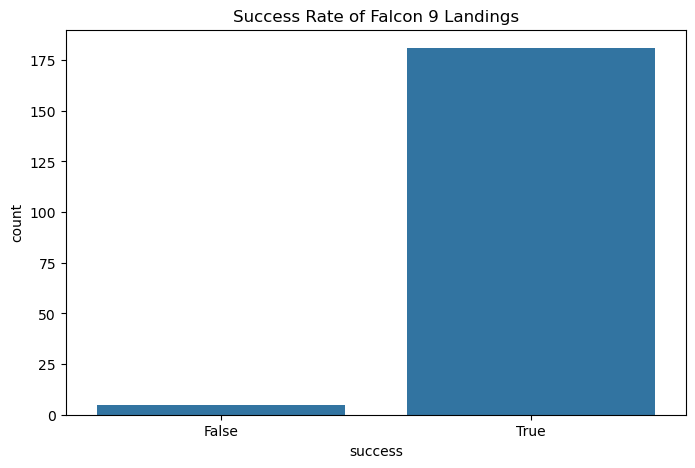

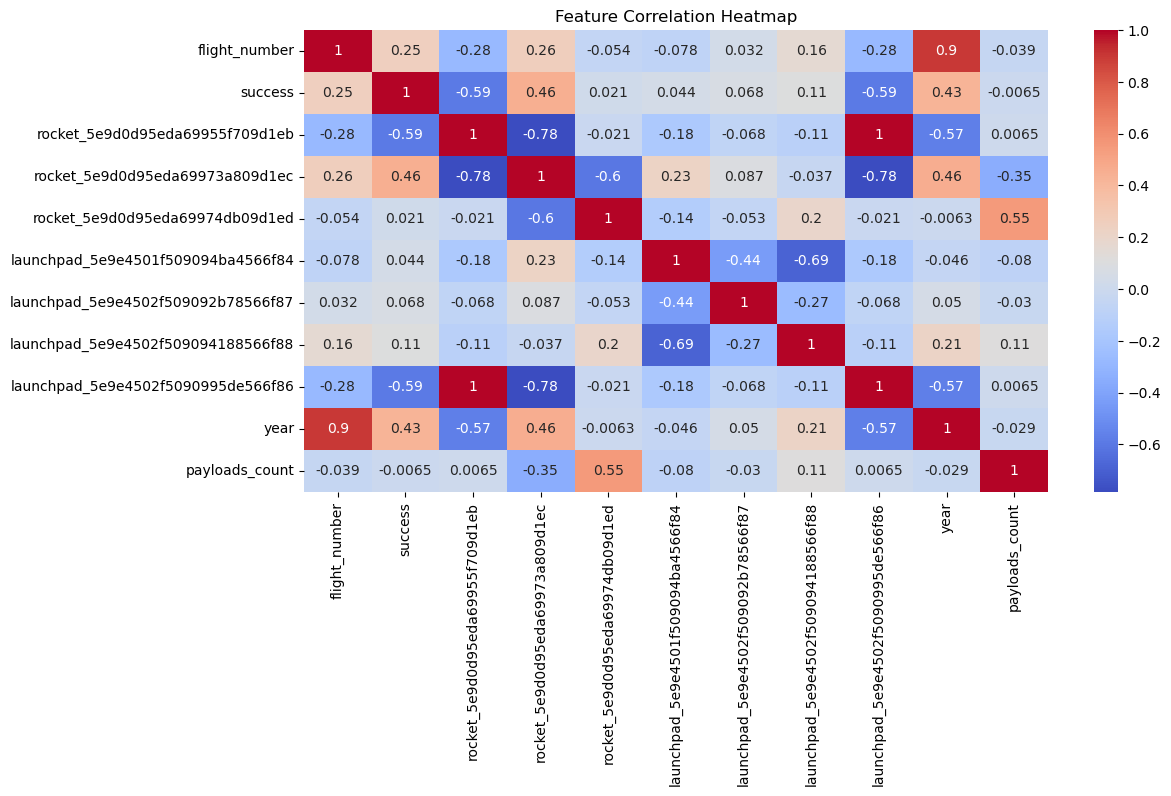

In [122]:
# Preprocess the 'payloads' column to extract the length of the payloads list
df['payloads_count'] = df['payloads'].apply(lambda x: len(eval(x)) if isinstance(x, str) else 0)

# Visualizing Landing Success
plt.figure(figsize=(8, 5))
sns.countplot(x=df['success'])
plt.title("Success Rate of Falcon 9 Landings")
plt.show()

# Correlation Heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(df.drop(columns=['payloads']).corr(), annot=True, cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.show()


Check Dataset Shapes Before Splitting

In [123]:
print("Feature set (X) shape:", X.shape)
print("Target variable (y) shape:", y.shape)

Feature set (X) shape: (186, 11)
Target variable (y) shape: (186,)


Check for Missing Values

In [124]:
print("Missing values in X:\n", X.isnull().sum())
print("Missing values in y:\n", y.isnull().sum())

Missing values in X:
 flight_number                         0
payloads                              0
rocket_5e9d0d95eda69955f709d1eb       0
rocket_5e9d0d95eda69973a809d1ec       0
rocket_5e9d0d95eda69974db09d1ed       0
launchpad_5e9e4501f509094ba4566f84    0
launchpad_5e9e4502f509092b78566f87    0
launchpad_5e9e4502f509094188566f88    0
launchpad_5e9e4502f5090995de566f86    0
year                                  0
payloads_count                        0
dtype: int64
Missing values in y:
 0


Fix missing values if found

In [125]:
X = X.dropna()
y = y.loc[X.index]  # Ensure alignment

## Phase 5: Machine Learning Model Development

Split Data for Training & Testing

In [126]:
# Define target variable
X = df.drop(columns=['success'])
y = df['success']

# Split into train-test sets (80%-20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training and test sets ready!")

Training and test sets ready!


 Train Multiple Models

In [ ]:
# Ensure y_train contains only discrete classes
y_train = y_train.astype('bool')
y_test = y_test.astype('bool')

# Train Logistic Regression
log_model = LogisticRegression()
log_model.fit(X_train, y_train)

# Train Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Train Decision Tree
dt_model = DecisionTreeClassifier(max_depth=5, random_state=42)
dt_model.fit(X_train, y_train)

# Train Support Vector Machine (SVM)
svm_model = SVC(kernel='linear')
svm_model.fit(X_train, y_train)

print("Models trained successfully!")

In [ ]:
import pandas as pd
import numpy as np
import requests
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

# Fetch SpaceX data
spacex_url = "https://api.spacexdata.com/v4/launches"
response = requests.get(spacex_url)

if response.status_code == 200:
    launches_data = response.json()
    print("Data fetched successfully!")
else:
    print("Error fetching data!")

# Convert JSON data to Pandas DataFrame
df = pd.json_normalize(launches_data)

# Select relevant columns (drop JSON objects that cannot be converted directly)
columns_needed = ['flight_number', 'date_utc', 'rocket', 'success', 'payloads', 'launchpad']
df = df[columns_needed]

# Drop rows with missing values in key columns
df = df.dropna(subset=['rocket', 'launchpad', 'date_utc', 'flight_number', 'success'])

# Convert categorical features using One-Hot Encoding
encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
encoded_features = encoder.fit_transform(df[['rocket', 'launchpad']])
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out())

# Merge encoded data and remove original categorical columns
df = df.drop(columns=['rocket', 'launchpad'])
df = pd.concat([df, encoded_df], axis=1)

# Convert date column to datetime and extract year
df['date_utc'] = pd.to_datetime(df['date_utc'])
df['year'] = df['date_utc'].dt.year
df = df.drop(columns=['date_utc'])

# Normalize numerical features
scaler = StandardScaler()
df[['flight_number', 'year']] = scaler.fit_transform(df[['flight_number', 'year']])

# Ensure target variable is correctly formatted
df['success'] = df['success'].astype(int)  # Convert success column to binary 0/1

# Split into features (X) and target (y)
X = df.drop(columns=['success'])
y = df['success']

# Split into training and testing sets (80%-20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Confirm shape consistency
print("Training feature set shape:", X_train.shape)
print("Training target set shape:", y_train.shape)
print("Testing feature set shape:", X_test.shape)
print("Testing target set shape:", y_test.shape)

# Train logistic regression model
log_model = LogisticRegression()
log_model.fit(X_train, y_train)

# Train random forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Train decision tree model
dt_model = DecisionTreeClassifier(max_depth=5, random_state=42)
dt_model.fit(X_train, y_train)

# Train support vector machine (SVM)
svm_model = SVC(kernel='linear')
svm_model.fit(X_train, y_train)

print("Models trained successfully!")


TASK 1: Falcon 9 Launches from Wiki Pages URL

In [ ]:
from bs4 import BeautifulSoup

# Step 1: Fetch the webpage
#response = requests.get(static_url)
response = requests.get(spacex_url)

# Step 2: Check if the response is successful
if response.status_code == 200:
    print("Successfully fetched the URL content.")
else:
    print(f"Failed to fetch the URL. Status code: {response.status_code}")

# Step 3: Parse the response with BeautifulSoup
soup = BeautifulSoup(response.content, "html.parser")

# Step 4: Extract the title
if soup.title:
    webpage_title = soup.title.string
    print("Webpage Title:", webpage_title)
else:
    print("No title found on the webpage.")


Successfully fetched the URL content.
No title found on the webpage.


Create Beautiful Soup Object from the HTML

In [78]:
# Create a BeautifulSoup object from the response content
soup = BeautifulSoup(response.text, "html.parser")

# Use the title attribute to get the title from the HTML page
page_title = soup.title.string

# Print the title
print("Page Title:", page_title)


Page Title: List of Falcon 9 and Falcon Heavy launches (2010–2019) - Wikipedia


TASK 2: Extract all column/Variable names for HTML table header 

In [79]:
# Step 1: Use the find_all() function to find all 'table' elements in the HTML page
html_tables = soup.find_all("table")

# Step 2: Assign the results to a list called 'HTML_Table'
HTML_Table = list(html_tables)

# Step 3: Print the number of tables found and display the first table as an example
print(f"Number of tables found: {len(HTML_Table)}")

# Display the first table (if available)
if len(HTML_Table) > 0:
    print("First table HTML:")
    print(HTML_Table[0].prettify())
else:
    print("No tables found in the HTML content.")


Number of tables found: 18
First table HTML:
<table class="wikitable plainrowheaders sticky-header collapsible" style="width: 100%;">
 <tbody>
  <tr>
   <th scope="col">
    <br/>
    Flight No.
   </th>
   <th scope="col">
    Date and
    <br/>
    time (
    <a href="/wiki/Coordinated_Universal_Time" title="Coordinated Universal Time">
     UTC
    </a>
    )
   </th>
   <th scope="col">
    <a href="/wiki/List_of_Falcon_9_first-stage_boosters" title="List of Falcon 9 first-stage boosters">
     Version,
     <br/>
     booster
    </a>
    <sup class="reference" id="cite_ref-booster_5-0">
     <a href="#cite_note-booster-5">
      <span class="cite-bracket">
       [
      </span>
      a
      <span class="cite-bracket">
       ]
      </span>
     </a>
    </sup>
    <br/>
    <sup class="reference" id="cite_ref-MuskMay2012_6-0">
     <a href="#cite_note-MuskMay2012-6">
      <span class="cite-bracket">
       [
      </span>
      2
      <span class="cite-bracket">
       ]
   

Next, we just need to iterate through the `<th>` elements and apply the provided `extract_column_from_header()` to extract column name one by one

In [80]:
# Define the `extract_column_from_header` function to extract text from a header element
def extract_column_from_header(th_element):
    """
    Extracts the column name from a <th> element.
    Returns the stripped text content or None if empty.
    """
    if th_element:
        return th_element.text.strip()
    return None

# Assume `HTML_Table[0]` is the table we are working with
first_launch_table = HTML_Table[0] if len(HTML_Table) > 0 else None

# Initialize an empty list to store column names
column_names = []

# Check if the first_launch_table is not None
if first_launch_table:
    # Find all <th> elements in the first table
    th_elements = first_launch_table.find_all("th")

    # Iterate over each <th> element to extract column names
    for th in th_elements:
        column_name = extract_column_from_header(th)
        # Append non-empty column names to the list
        if column_name is not None and len(column_name) > 0:
            column_names.append(column_name)

# Display the extracted column names
print("Extracted Column Names:")
for i, column_name in enumerate(column_names, start=1):
    print(f"{i}. {column_name}")

Extracted Column Names:
1. Flight No.
2. Date andtime (UTC)
3. Version,booster[a][2][3]
4. Launchsite
5. Payload
6. Payload mass
7. Orbit
8. Customer
9. Launchoutcome
10. Boosterlanding
11. 1
12. 2
13. 3
14. 4
15. 5
16. 6
17. 7


In [81]:
print(column_names)
#print(f"{i}. {column_name}")

['Flight No.', 'Date andtime (UTC)', 'Version,booster[a][2][3]', 'Launchsite', 'Payload', 'Payload mass', 'Orbit', 'Customer', 'Launchoutcome', 'Boosterlanding', '1', '2', '3', '4', '5', '6', '7']


TASK 3: Create a data frame by parsing the launch HTML tables

In [82]:
launch_dict= dict.fromkeys(column_names)

# Remove an irrelevant column if it exists
launch_dict.pop('Date and time ( )', None)

# Let's initialize the launch_dict with each value to be an empty list
launch_dict['Flight No.'] = []
launch_dict['Launch site'] = []
launch_dict['Payload'] = []
launch_dict['Payload mass'] = []
launch_dict['Orbit'] = []
launch_dict['Customer'] = []
launch_dict['Launch outcome'] = []
# Added some new columns
launch_dict['Version Booster']=[]
launch_dict['Booster landing']=[]
launch_dict['Date']=[]
launch_dict['Time']=[]

Added new columns

In [83]:
extracted_row = 0
#Extract each table 
for table_number,table in enumerate(soup.find_all('table',"wikitable plainrowheaders collapsible")):
   # get table row 
    for rows in table.find_all("tr"):
        #check to see if first table heading is as number corresponding to launch a number 
        if rows.th:
            if rows.th.string:
                flight_number=rows.th.string.strip()
                flag=flight_number.isdigit()
        else:
            flag=False
        #get table element 
        row=rows.find_all('td')
        #if it is number save cells in a dictonary 
        if flag:
            extracted_row += 1
            # Flight Number value
            # TODO: Append the flight_number into launch_dict with key `Flight No.`
            #print(flight_number)
            datatimelist=date_time(row[0])
            
            # Date value
            # TODO: Append the date into launch_dict with key `Date`
            date = datatimelist[0].strip(',')
            #print(date)
            
            # Time value
            # TODO: Append the time into launch_dict with key `Time`
            time = datatimelist[1]
            #print(time)
              
            # Booster version
            # TODO: Append the bv into launch_dict with key `Version Booster`
            bv=booster_version(row[1])
            if not(bv):
                bv=row[1].a.string
            print(bv)
            
            # Launch Site
            # TODO: Append the bv into launch_dict with key `Launch Site`
            launch_site = row[2].a.string
            #print(launch_site)
            
            # Payload
            # TODO: Append the payload into launch_dict with key `Payload`
            payload = row[3].a.string
            #print(payload)
            
            # Payload Mass
            # TODO: Append the payload_mass into launch_dict with key `Payload mass`
            payload_mass = get_mass(row[4])
            #print(payload)
            
            # Orbit
            # TODO: Append the orbit into launch_dict with key `Orbit`
            orbit = row[5].a.string
            #print(orbit)
            
            # Customer
            # TODO: Append the customer into launch_dict with key `Customer`
            customer = row[6].a.string
            #print(customer)
            
            # Launch outcome
            # TODO: Append the launch_outcome into launch_dict with key `Launch outcome`
            launch_outcome = list(row[7].strings)[0]
            #print(launch_outcome)
            
            # Booster landing
            # TODO: Append the launch_outcome into launch_dict with key `Booster landing`
            booster_landing = landing_status(row[8])
            #print(booster_landing)
            

Create the DataFrame from the dictionary

In [84]:
# Assuming launch_dict is a properly formatted dictionary
# Create the DataFrame from the dictionary
df = pd.DataFrame({key: pd.Series(value) for key, value in launch_dict.items()})

# Display the resulting DataFrame
print(df)


Empty DataFrame
Columns: [Flight No., Date andtime (UTC), Version,booster[a][2][3], Launchsite, Payload, Payload mass, Orbit, Customer, Launchoutcome, Boosterlanding, 1, 2, 3, 4, 5, 6, 7, Launch site, Launch outcome, Version Booster, Booster landing, Date, Time]
Index: []

[0 rows x 23 columns]


Save file as CSV

In [85]:
df.to_csv('spacex_web_scraped.csv', index=False)